# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)


In [3]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)
window_size = 10
stride = 5

In [4]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [5]:
mask = df['label'] != 5
df = df[mask]

In [6]:
# 🎯 Entrenar solo con 3 clases: 1, 2, 3 (sin clase 4)
print("📊 Clases disponibles:")
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'   Label {i}: {mask} muestras')

# Filtrar para mantener solo las clases 1, 2, 3
print("\n🎯 Filtrando para mantener solo clases 1, 2, 3...")
df = df[df['label'].isin([1, 2, 3])].copy()

print("\n📊 Después del filtrado:")
for i in sorted(df['label'].unique()):
    mask = (df['label'] == i).sum()
    print(f'   Label {i}: {mask} muestras')

print(f"\n✅ Dataset listo con {len(df['label'].unique())} clases para entrenamiento")

📊 Clases disponibles:
   Label 1: 73554 muestras
   Label 2: 48333 muestras
   Label 3: 42875 muestras
   Label 4: 43068 muestras

🎯 Filtrando para mantener solo clases 1, 2, 3...

📊 Después del filtrado:
   Label 1: 73554 muestras
   Label 2: 48333 muestras
   Label 3: 42875 muestras

✅ Dataset listo con 3 clases para entrenamiento


In [7]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875


In [8]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [9]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen las 3 clases (0, 1, 2 después del LabelEncoder)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 3].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(115733, 52)
(115733,)


In [10]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=window_size, stride=stride)

In [11]:
print(X_seq.shape)

(23112, 10, 52)


In [12]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


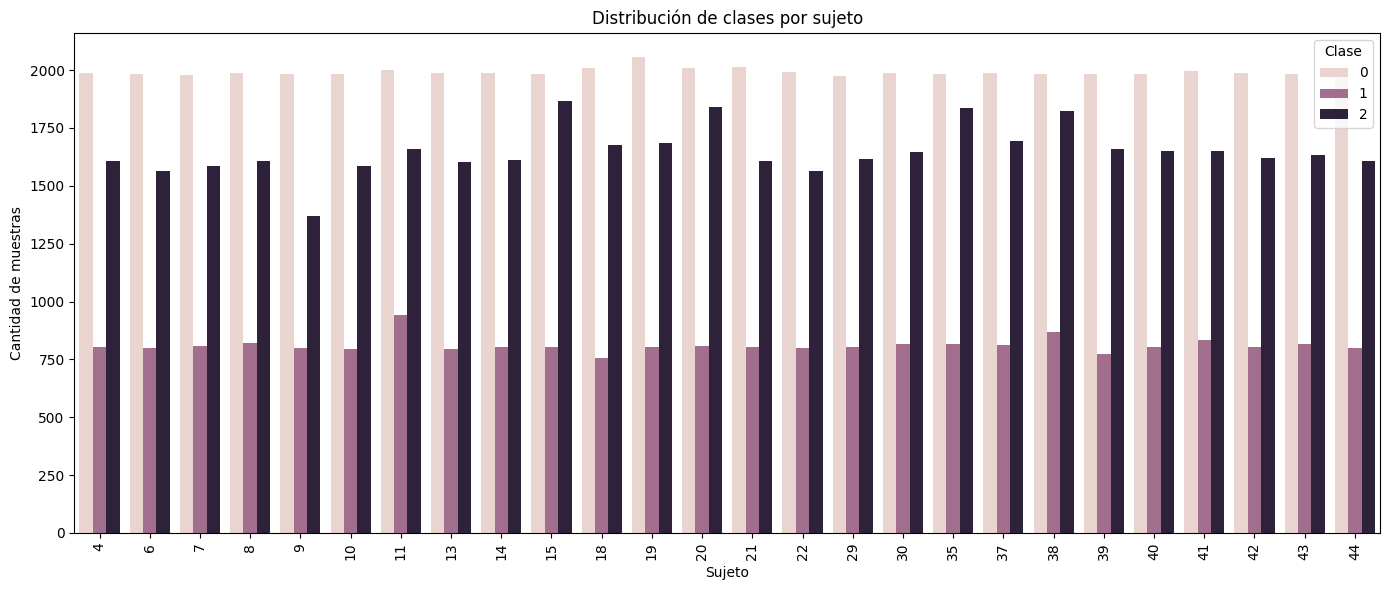

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()


🧪 Validando grupo 1 de 37
Clases en test (sujeto 1): {0: 396, 1: 160, 2: 322}
Epoch 1/50
348/348 [==============================] - 7s 6ms/step - loss: 1.0877 - accuracy: 0.3796 - val_loss: 1.0786 - val_accuracy: 0.5399

Epoch 00001: val_accuracy improved from -inf to 0.53986, saving model to modelos_m\mejor_modelo_1.h5
Epoch 2/50
348/348 [==============================] - 2s 4ms/step - loss: 1.0705 - accuracy: 0.4854 - val_loss: 1.0568 - val_accuracy: 0.7027

Epoch 00002: val_accuracy improved from 0.53986 to 0.70273, saving model to modelos_m\mejor_modelo_1.h5
Epoch 3/50
348/348 [==============================] - 2s 4ms/step - loss: 1.0420 - accuracy: 0.5935 - val_loss: 1.0235 - val_accuracy: 0.7437

Epoch 00003: val_accuracy improved from 0.70273 to 0.74374, saving model to modelos_m\mejor_modelo_1.h5
Epoch 4/50
348/348 [==============================] - 2s 4ms/step - loss: 1.0024 - accuracy: 0.6675 - val_loss: 0.9798 - val_accuracy: 0.7563

Epoch 00004: val_accuracy improved from 

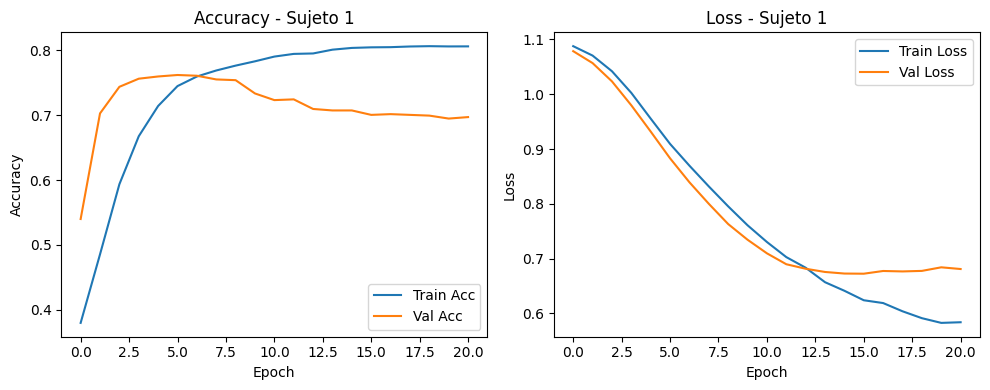

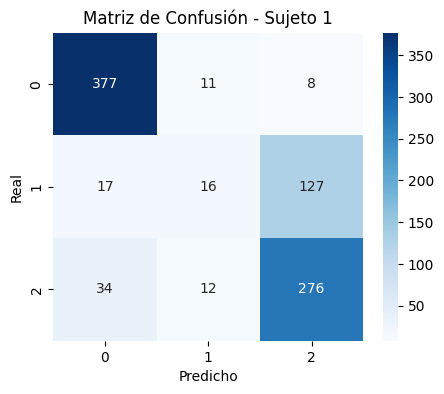

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.8808    0.9520    0.9150       396
           1     0.4103    0.1000    0.1608       160
           2     0.6715    0.8571    0.7531       322

    accuracy                         0.7620       878
   macro avg     0.6542    0.6364    0.6096       878
weighted avg     0.7183    0.7620    0.7182       878


🧪 Validando grupo 2 de 37
Clases en test (sujeto 2): {0: 395, 1: 160, 2: 313}
Epoch 1/50
348/348 [==============================] - 5s 7ms/step - loss: 1.0938 - accuracy: 0.4344 - val_loss: 1.0807 - val_accuracy: 0.5253

Epoch 00001: val_accuracy improved from -inf to 0.52535, saving model to modelos_m\mejor_modelo_2.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0810 - accuracy: 0.5130 - val_loss: 1.0687 - val_accuracy: 0.6325

Epoch 00002: val_accuracy improved from 0.52535 to 0.63249, saving model to modelos_m\mejor_modelo_2.h5
Epoch 3/50


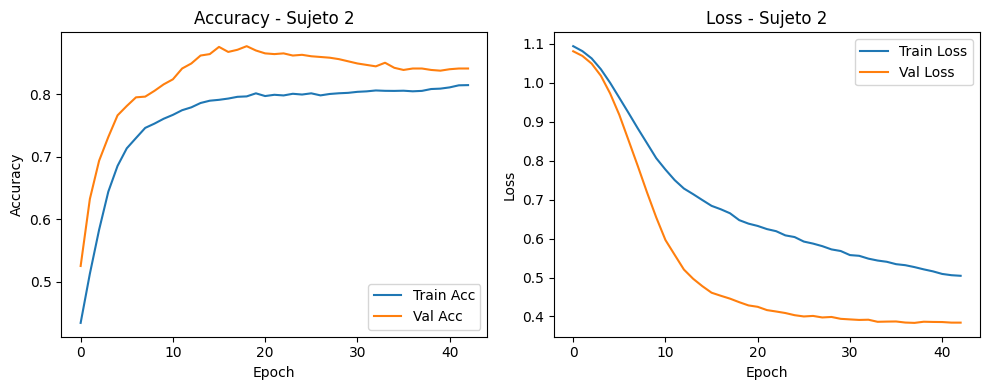

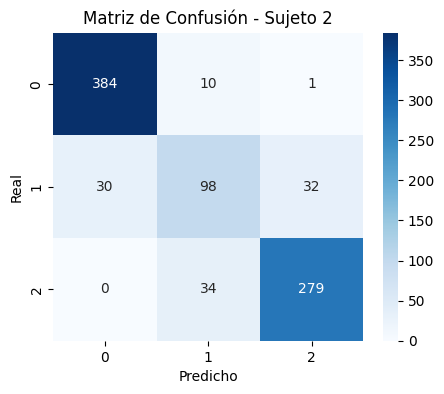

📄 Reporte de clasificación - Sujeto 2
              precision    recall  f1-score   support

           0     0.9275    0.9722    0.9493       395
           1     0.6901    0.6125    0.6490       160
           2     0.8942    0.8914    0.8928       313

    accuracy                         0.8767       868
   macro avg     0.8373    0.8253    0.8304       868
weighted avg     0.8718    0.8767    0.8736       868


🧪 Validando grupo 3 de 37
Clases en test (sujeto 3): {0: 394, 1: 161, 2: 318}
Epoch 1/50
348/348 [==============================] - 5s 7ms/step - loss: 1.0980 - accuracy: 0.3296 - val_loss: 1.0939 - val_accuracy: 0.3998

Epoch 00001: val_accuracy improved from -inf to 0.39977, saving model to modelos_m\mejor_modelo_3.h5
Epoch 2/50
348/348 [==============================] - 2s 4ms/step - loss: 1.0870 - accuracy: 0.4132 - val_loss: 1.0758 - val_accuracy: 0.5682

Epoch 00002: val_accuracy improved from 0.39977 to 0.56816, saving model to modelos_m\mejor_modelo_3.h5
Epoch 3/50


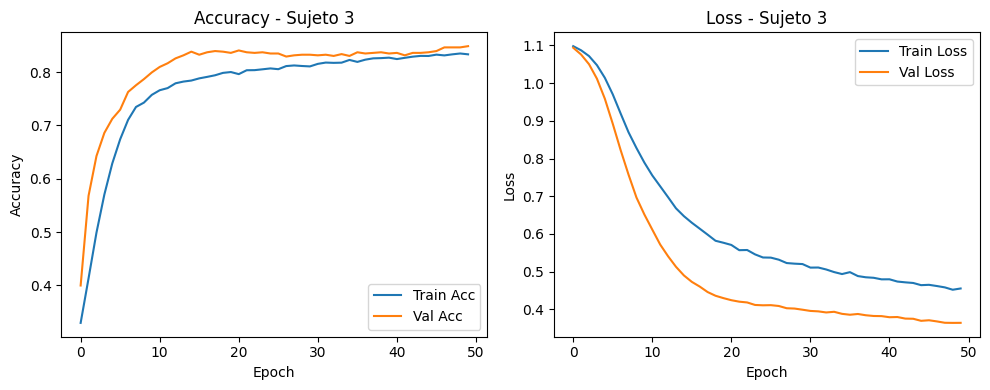

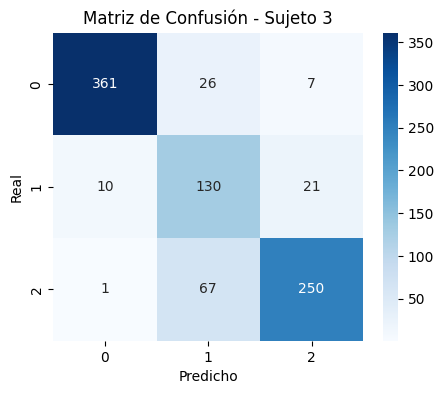

📄 Reporte de clasificación - Sujeto 3
              precision    recall  f1-score   support

           0     0.9704    0.9162    0.9426       394
           1     0.5830    0.8075    0.6771       161
           2     0.8993    0.7862    0.8389       318

    accuracy                         0.8488       873
   macro avg     0.8176    0.8366    0.8195       873
weighted avg     0.8731    0.8488    0.8559       873


🧪 Validando grupo 4 de 37
Clases en test (sujeto 4): {0: 396, 1: 164, 2: 321}
Epoch 1/50
348/348 [==============================] - 5s 7ms/step - loss: 1.0934 - accuracy: 0.4134 - val_loss: 1.0837 - val_accuracy: 0.5448

Epoch 00001: val_accuracy improved from -inf to 0.54484, saving model to modelos_m\mejor_modelo_4.h5
Epoch 2/50
348/348 [==============================] - 2s 4ms/step - loss: 1.0823 - accuracy: 0.5009 - val_loss: 1.0725 - val_accuracy: 0.6277

Epoch 00002: val_accuracy improved from 0.54484 to 0.62770, saving model to modelos_m\mejor_modelo_4.h5
Epoch 3/50


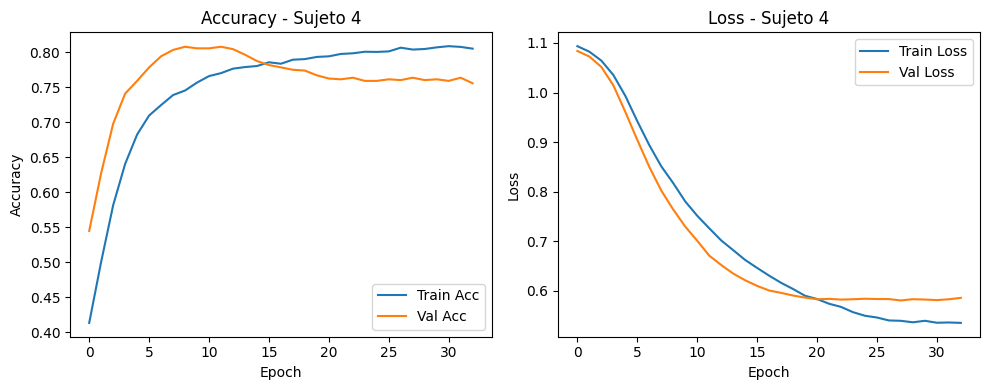

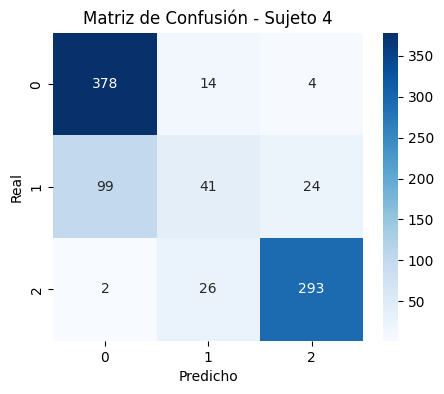

📄 Reporte de clasificación - Sujeto 4
              precision    recall  f1-score   support

           0     0.7891    0.9545    0.8640       396
           1     0.5062    0.2500    0.3347       164
           2     0.9128    0.9128    0.9128       321

    accuracy                         0.8082       881
   macro avg     0.7360    0.7058    0.7038       881
weighted avg     0.7815    0.8082    0.7832       881


🧪 Validando grupo 5 de 37
Clases en test (sujeto 5): {0: 395, 1: 160, 2: 274}
Epoch 1/50
349/349 [==============================] - 5s 8ms/step - loss: 1.0896 - accuracy: 0.4586 - val_loss: 1.0718 - val_accuracy: 0.5838

Epoch 00001: val_accuracy improved from -inf to 0.58384, saving model to modelos_m\mejor_modelo_5.h5
Epoch 2/50
349/349 [==============================] - 2s 5ms/step - loss: 1.0700 - accuracy: 0.5633 - val_loss: 1.0357 - val_accuracy: 0.6779

Epoch 00002: val_accuracy improved from 0.58384 to 0.67793, saving model to modelos_m\mejor_modelo_5.h5
Epoch 3/50


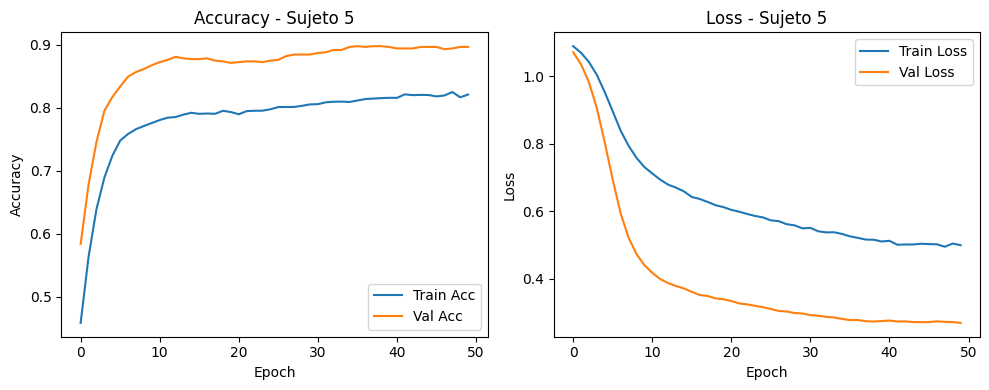

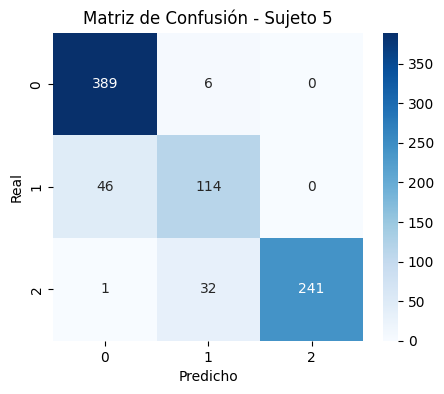

📄 Reporte de clasificación - Sujeto 5
              precision    recall  f1-score   support

           0     0.8922    0.9848    0.9362       395
           1     0.7500    0.7125    0.7308       160
           2     1.0000    0.8796    0.9359       274

    accuracy                         0.8975       829
   macro avg     0.8807    0.8590    0.8676       829
weighted avg     0.9004    0.8975    0.8965       829


🧪 Validando grupo 6 de 37
Clases en test (sujeto 6): {0: 396, 1: 159, 2: 317}
Epoch 1/50
348/348 [==============================] - 5s 7ms/step - loss: 1.0917 - accuracy: 0.3574 - val_loss: 1.0885 - val_accuracy: 0.4266

Epoch 00001: val_accuracy improved from -inf to 0.42661, saving model to modelos_m\mejor_modelo_6.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0816 - accuracy: 0.4180 - val_loss: 1.0806 - val_accuracy: 0.4977

Epoch 00002: val_accuracy improved from 0.42661 to 0.49771, saving model to modelos_m\mejor_modelo_6.h5
Epoch 3/50


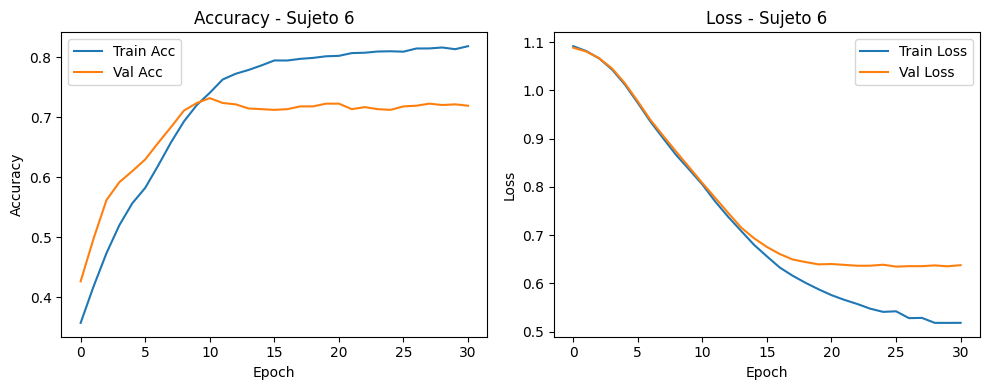

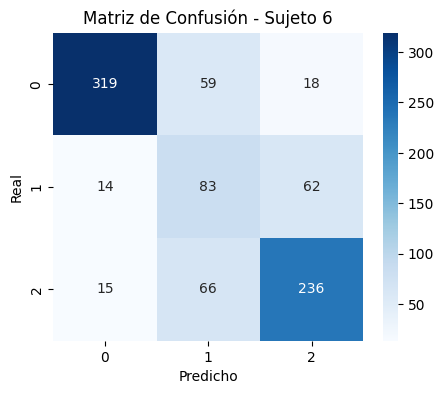

📄 Reporte de clasificación - Sujeto 6
              precision    recall  f1-score   support

           0     0.9167    0.8056    0.8575       396
           1     0.3990    0.5220    0.4523       159
           2     0.7468    0.7445    0.7457       317

    accuracy                         0.7317       872
   macro avg     0.6875    0.6907    0.6852       872
weighted avg     0.7605    0.7317    0.7430       872


🧪 Validando grupo 7 de 37
Clases en test (sujeto 7): {0: 399, 1: 188, 2: 332}
Epoch 1/50
347/347 [==============================] - 4s 6ms/step - loss: 1.0892 - accuracy: 0.4190 - val_loss: 1.0792 - val_accuracy: 0.5669

Epoch 00001: val_accuracy improved from -inf to 0.56692, saving model to modelos_m\mejor_modelo_7.h5
Epoch 2/50
347/347 [==============================] - 2s 5ms/step - loss: 1.0758 - accuracy: 0.5134 - val_loss: 1.0564 - val_accuracy: 0.6431

Epoch 00002: val_accuracy improved from 0.56692 to 0.64309, saving model to modelos_m\mejor_modelo_7.h5
Epoch 3/50


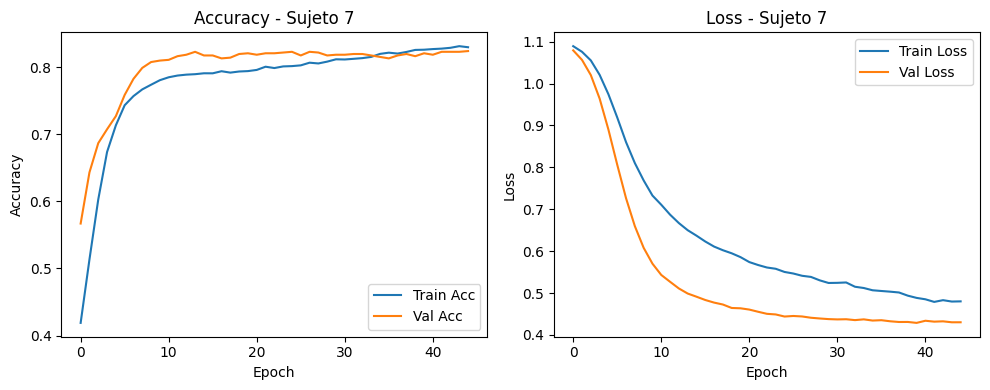

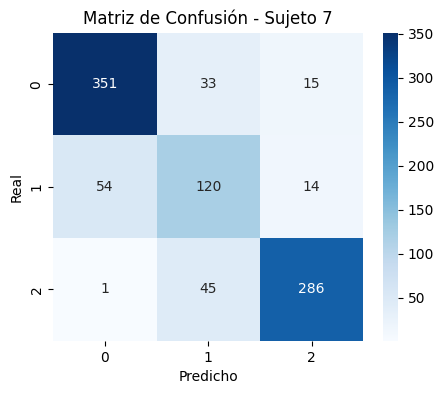

📄 Reporte de clasificación - Sujeto 7
              precision    recall  f1-score   support

           0     0.8645    0.8797    0.8720       399
           1     0.6061    0.6383    0.6218       188
           2     0.9079    0.8614    0.8841       332

    accuracy                         0.8237       919
   macro avg     0.7928    0.7931    0.7926       919
weighted avg     0.8273    0.8237    0.8252       919


🧪 Validando grupo 8 de 37
Clases en test (sujeto 8): {0: 396, 1: 159, 2: 321}
Epoch 1/50
348/348 [==============================] - 5s 8ms/step - loss: 1.0934 - accuracy: 0.3914 - val_loss: 1.0761 - val_accuracy: 0.6119

Epoch 00001: val_accuracy improved from -inf to 0.61187, saving model to modelos_m\mejor_modelo_8.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0779 - accuracy: 0.5118 - val_loss: 1.0476 - val_accuracy: 0.7363

Epoch 00002: val_accuracy improved from 0.61187 to 0.73630, saving model to modelos_m\mejor_modelo_8.h5
Epoch 3/50


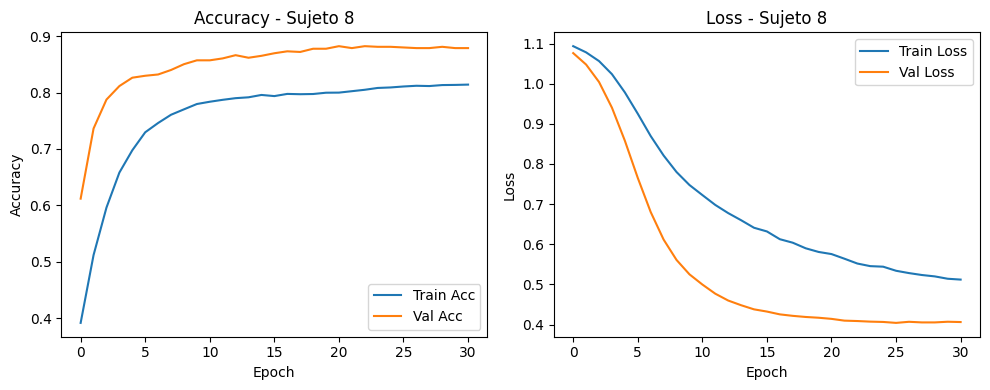

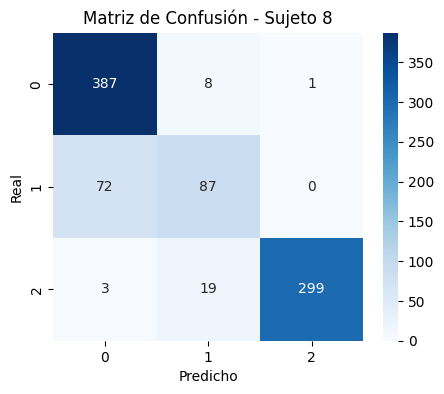

📄 Reporte de clasificación - Sujeto 8
              precision    recall  f1-score   support

           0     0.8377    0.9773    0.9021       396
           1     0.7632    0.5472    0.6374       159
           2     0.9967    0.9315    0.9630       321

    accuracy                         0.8824       876
   macro avg     0.8658    0.8186    0.8341       876
weighted avg     0.8824    0.8824    0.8763       876


🧪 Validando grupo 9 de 37
Clases en test (sujeto 9): {0: 396, 1: 161, 2: 322}
Epoch 1/50
348/348 [==============================] - 5s 7ms/step - loss: 1.0957 - accuracy: 0.3757 - val_loss: 1.0894 - val_accuracy: 0.5154

Epoch 00001: val_accuracy improved from -inf to 0.51536, saving model to modelos_m\mejor_modelo_9.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0861 - accuracy: 0.4649 - val_loss: 1.0779 - val_accuracy: 0.5882

Epoch 00002: val_accuracy improved from 0.51536 to 0.58817, saving model to modelos_m\mejor_modelo_9.h5
Epoch 3/50


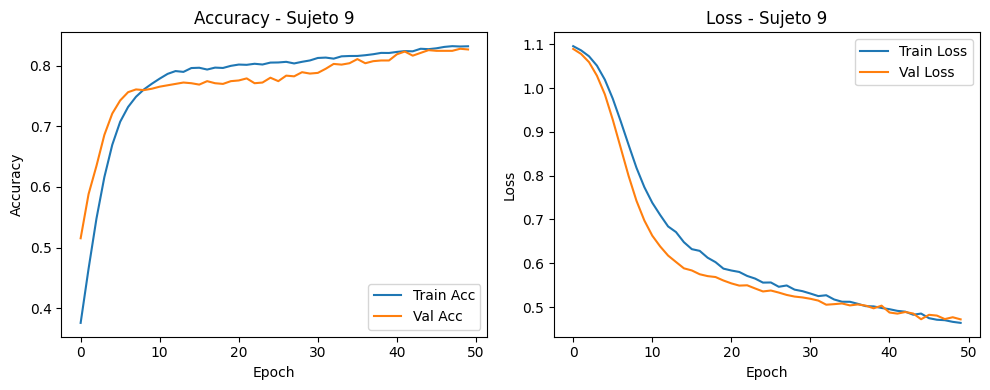

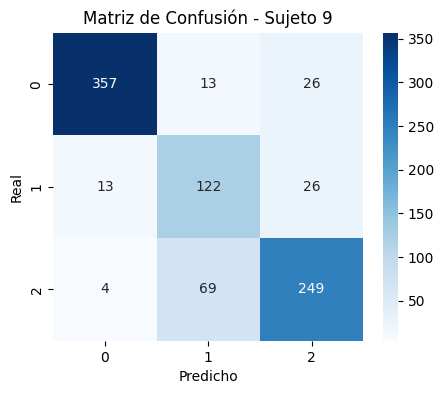

📄 Reporte de clasificación - Sujeto 9
              precision    recall  f1-score   support

           0     0.9545    0.9015    0.9273       396
           1     0.5980    0.7578    0.6685       161
           2     0.8272    0.7733    0.7994       322

    accuracy                         0.8282       879
   macro avg     0.7933    0.8109    0.7984       879
weighted avg     0.8426    0.8282    0.8330       879


🧪 Validando grupo 10 de 37
Clases en test (sujeto 10): {0: 396, 1: 160, 2: 374}
Epoch 1/50
347/347 [==============================] - 5s 7ms/step - loss: 1.0956 - accuracy: 0.2867 - val_loss: 1.0917 - val_accuracy: 0.4022

Epoch 00001: val_accuracy improved from -inf to 0.40215, saving model to modelos_m\mejor_modelo_10.h5
Epoch 2/50
347/347 [==============================] - 2s 5ms/step - loss: 1.0840 - accuracy: 0.3550 - val_loss: 1.0735 - val_accuracy: 0.5613

Epoch 00002: val_accuracy improved from 0.40215 to 0.56129, saving model to modelos_m\mejor_modelo_10.h5
Epoch 3

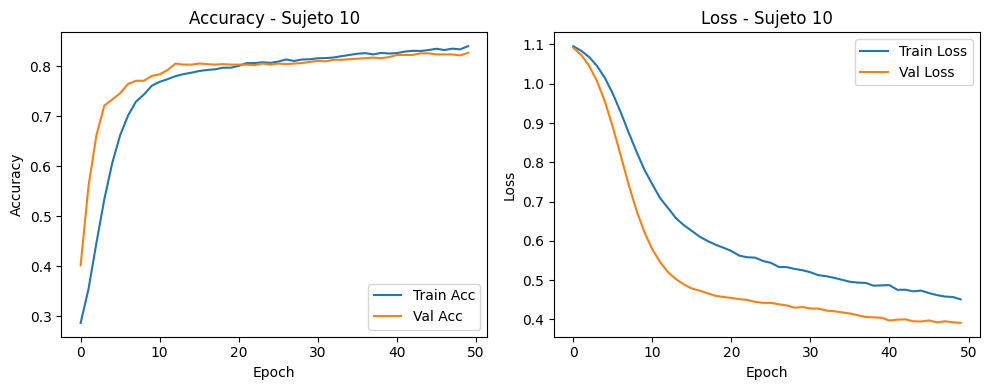

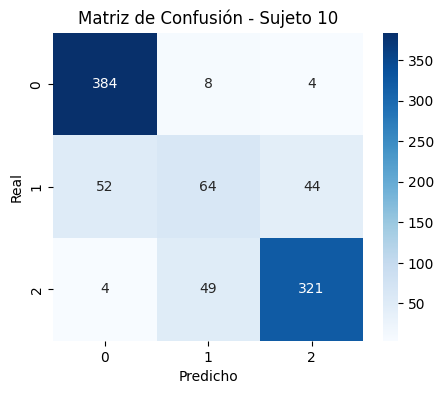

📄 Reporte de clasificación - Sujeto 10
              precision    recall  f1-score   support

           0     0.8727    0.9697    0.9187       396
           1     0.5289    0.4000    0.4555       160
           2     0.8699    0.8583    0.8641       374

    accuracy                         0.8269       930
   macro avg     0.7572    0.7427    0.7461       930
weighted avg     0.8124    0.8269    0.8170       930


🧪 Validando grupo 11 de 37
Clases en test (sujeto 11): {0: 401, 1: 151, 2: 335}
Epoch 1/50
348/348 [==============================] - 4s 7ms/step - loss: 1.0992 - accuracy: 0.2996 - val_loss: 1.0992 - val_accuracy: 0.2976

Epoch 00001: val_accuracy improved from -inf to 0.29763, saving model to modelos_m\mejor_modelo_11.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0906 - accuracy: 0.3672 - val_loss: 1.0910 - val_accuracy: 0.3709

Epoch 00002: val_accuracy improved from 0.29763 to 0.37091, saving model to modelos_m\mejor_modelo_11.h5
Epoch 

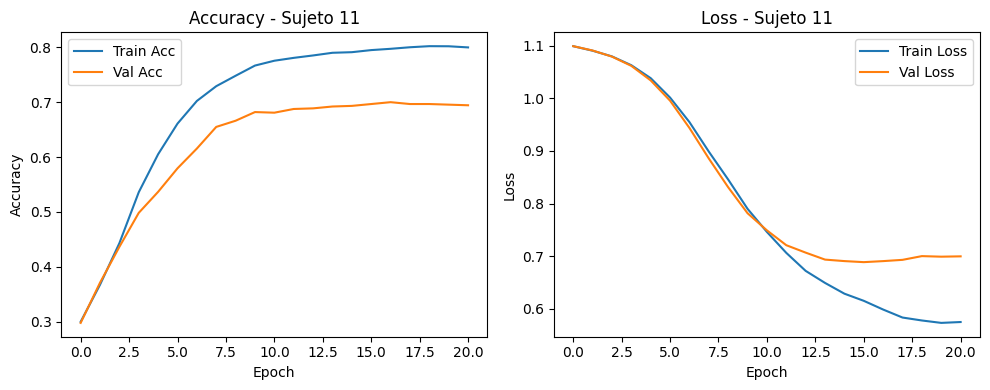

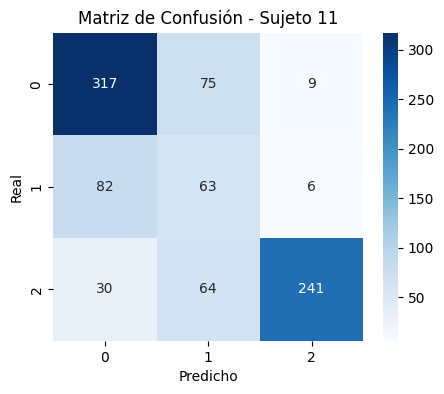

📄 Reporte de clasificación - Sujeto 11
              precision    recall  f1-score   support

           0     0.7389    0.7905    0.7639       401
           1     0.3119    0.4172    0.3569       151
           2     0.9414    0.7194    0.8156       335

    accuracy                         0.7001       887
   macro avg     0.6641    0.6424    0.6455       887
weighted avg     0.7427    0.7001    0.7141       887


🧪 Validando grupo 12 de 37
Clases en test (sujeto 12): {0: 410, 1: 161, 2: 337}
Epoch 1/50
347/347 [==============================] - 4s 7ms/step - loss: 1.0945 - accuracy: 0.4465 - val_loss: 1.0605 - val_accuracy: 0.6046

Epoch 00001: val_accuracy improved from -inf to 0.60463, saving model to modelos_m\mejor_modelo_12.h5
Epoch 2/50
347/347 [==============================] - 2s 5ms/step - loss: 1.0759 - accuracy: 0.5349 - val_loss: 1.0136 - val_accuracy: 0.7390

Epoch 00002: val_accuracy improved from 0.60463 to 0.73899, saving model to modelos_m\mejor_modelo_12.h5
Epoch 

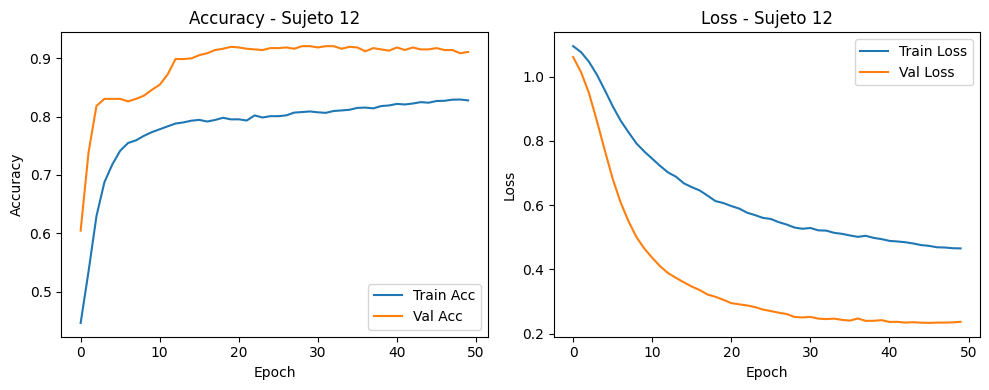

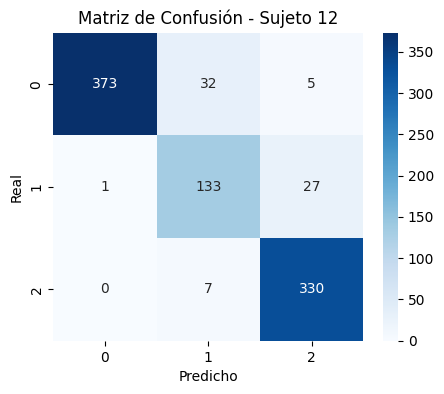

📄 Reporte de clasificación - Sujeto 12
              precision    recall  f1-score   support

           0     0.9973    0.9098    0.9515       410
           1     0.7733    0.8261    0.7988       161
           2     0.9116    0.9792    0.9442       337

    accuracy                         0.9207       908
   macro avg     0.8941    0.9050    0.8982       908
weighted avg     0.9258    0.9207    0.9217       908


🧪 Validando grupo 13 de 37
Clases en test (sujeto 13): {0: 400, 1: 162, 2: 367}
Epoch 1/50
347/347 [==============================] - 5s 8ms/step - loss: 1.0975 - accuracy: 0.4264 - val_loss: 1.0767 - val_accuracy: 0.5813

Epoch 00001: val_accuracy improved from -inf to 0.58127, saving model to modelos_m\mejor_modelo_13.h5
Epoch 2/50
347/347 [==============================] - 2s 5ms/step - loss: 1.0842 - accuracy: 0.5141 - val_loss: 1.0536 - val_accuracy: 0.7115

Epoch 00002: val_accuracy improved from 0.58127 to 0.71152, saving model to modelos_m\mejor_modelo_13.h5
Epoch 

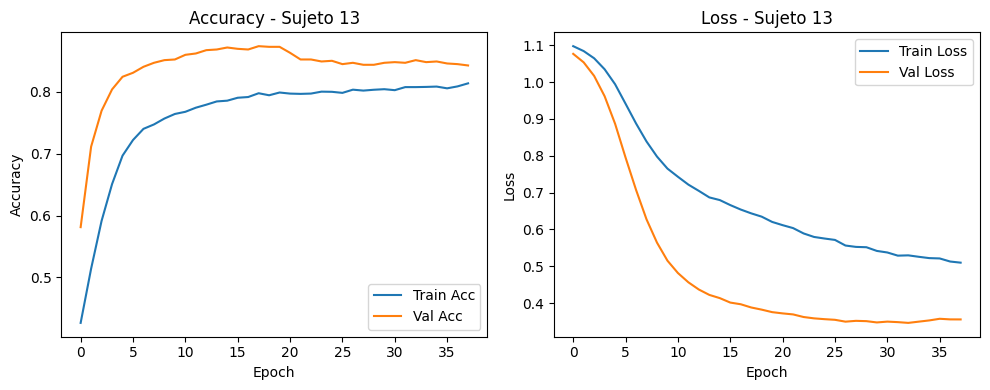

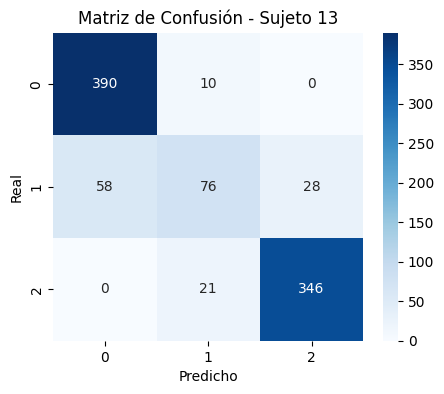

📄 Reporte de clasificación - Sujeto 13
              precision    recall  f1-score   support

           0     0.8705    0.9750    0.9198       400
           1     0.7103    0.4691    0.5651       162
           2     0.9251    0.9428    0.9339       367

    accuracy                         0.8741       929
   macro avg     0.8353    0.7956    0.8062       929
weighted avg     0.8642    0.8741    0.8635       929


🧪 Validando grupo 14 de 37
Clases en test (sujeto 14): {0: 401, 1: 161, 2: 322}
Epoch 1/50
348/348 [==============================] - 4s 7ms/step - loss: 1.0970 - accuracy: 0.3900 - val_loss: 1.0860 - val_accuracy: 0.5023

Epoch 00001: val_accuracy improved from -inf to 0.50226, saving model to modelos_m\mejor_modelo_14.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0880 - accuracy: 0.4781 - val_loss: 1.0656 - val_accuracy: 0.6369

Epoch 00002: val_accuracy improved from 0.50226 to 0.63688, saving model to modelos_m\mejor_modelo_14.h5
Epoch 

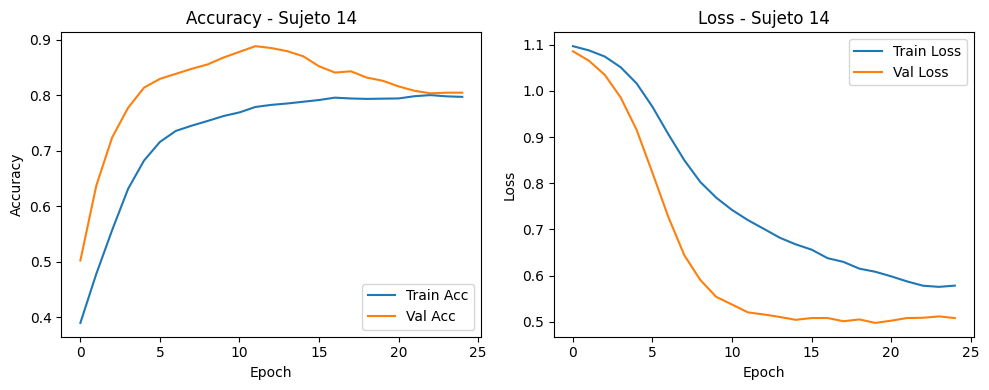

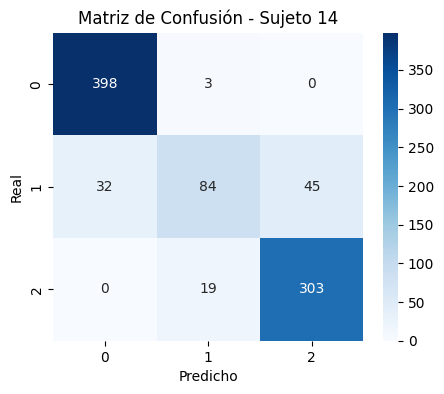

📄 Reporte de clasificación - Sujeto 14
              precision    recall  f1-score   support

           0     0.9256    0.9925    0.9579       401
           1     0.7925    0.5217    0.6292       161
           2     0.8707    0.9410    0.9045       322

    accuracy                         0.8880       884
   macro avg     0.8629    0.8184    0.8305       884
weighted avg     0.8813    0.8880    0.8786       884


🧪 Validando grupo 15 de 37
Clases en test (sujeto 15): {0: 397, 1: 160, 2: 313}
Epoch 1/50
348/348 [==============================] - 4s 7ms/step - loss: 1.0933 - accuracy: 0.3932 - val_loss: 1.0841 - val_accuracy: 0.4080

Epoch 00001: val_accuracy improved from -inf to 0.40805, saving model to modelos_m\mejor_modelo_15.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0809 - accuracy: 0.4708 - val_loss: 1.0600 - val_accuracy: 0.5379

Epoch 00002: val_accuracy improved from 0.40805 to 0.53793, saving model to modelos_m\mejor_modelo_15.h5
Epoch 

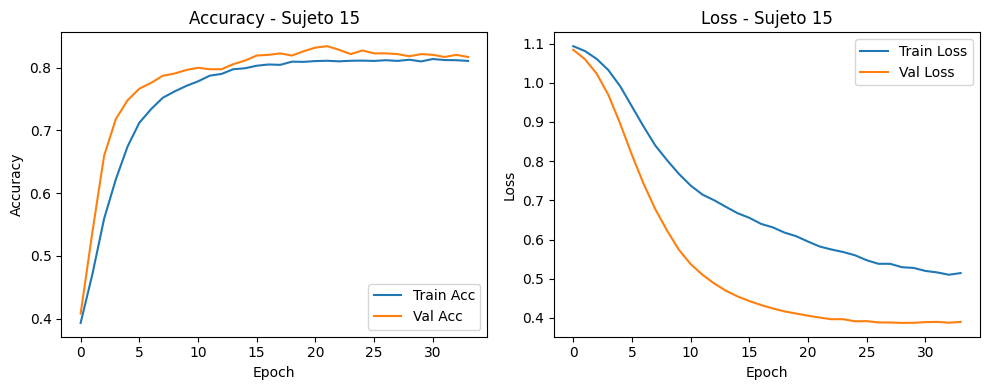

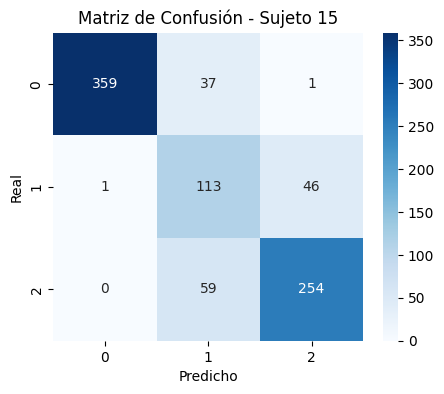

📄 Reporte de clasificación - Sujeto 15
              precision    recall  f1-score   support

           0     0.9972    0.9043    0.9485       397
           1     0.5407    0.7063    0.6125       160
           2     0.8439    0.8115    0.8274       313

    accuracy                         0.8345       870
   macro avg     0.7939    0.8073    0.7961       870
weighted avg     0.8581    0.8345    0.8431       870


🧪 Validando grupo 16 de 37
Clases en test (sujeto 16): {0: 393, 1: 161, 2: 324}
Epoch 1/50
348/348 [==============================] - 5s 7ms/step - loss: 1.0925 - accuracy: 0.4438 - val_loss: 1.0935 - val_accuracy: 0.3656

Epoch 00001: val_accuracy improved from -inf to 0.36560, saving model to modelos_m\mejor_modelo_16.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0816 - accuracy: 0.5308 - val_loss: 1.0856 - val_accuracy: 0.4396

Epoch 00002: val_accuracy improved from 0.36560 to 0.43964, saving model to modelos_m\mejor_modelo_16.h5
Epoch 

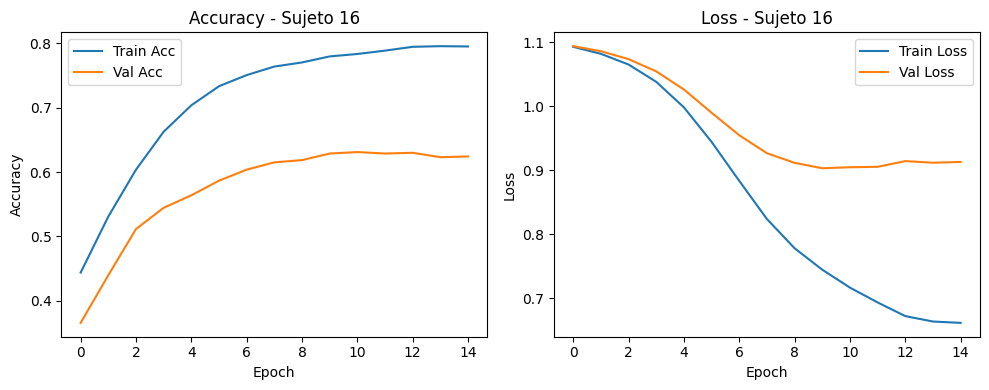

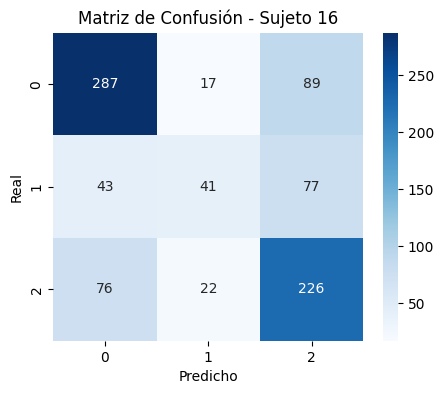

📄 Reporte de clasificación - Sujeto 16
              precision    recall  f1-score   support

           0     0.7069    0.7303    0.7184       393
           1     0.5125    0.2547    0.3402       161
           2     0.5765    0.6975    0.6313       324

    accuracy                         0.6310       878
   macro avg     0.5986    0.5608    0.5633       878
weighted avg     0.6231    0.6310    0.6169       878


🧪 Validando grupo 17 de 37
Clases en test (sujeto 17): {0: 396, 1: 163, 2: 330}
Epoch 1/50
348/348 [==============================] - 5s 8ms/step - loss: 1.0938 - accuracy: 0.2872 - val_loss: 1.0956 - val_accuracy: 0.2846

Epoch 00001: val_accuracy improved from -inf to 0.28459, saving model to modelos_m\mejor_modelo_17.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0845 - accuracy: 0.3459 - val_loss: 1.0856 - val_accuracy: 0.3611

Epoch 00002: val_accuracy improved from 0.28459 to 0.36108, saving model to modelos_m\mejor_modelo_17.h5
Epoch 

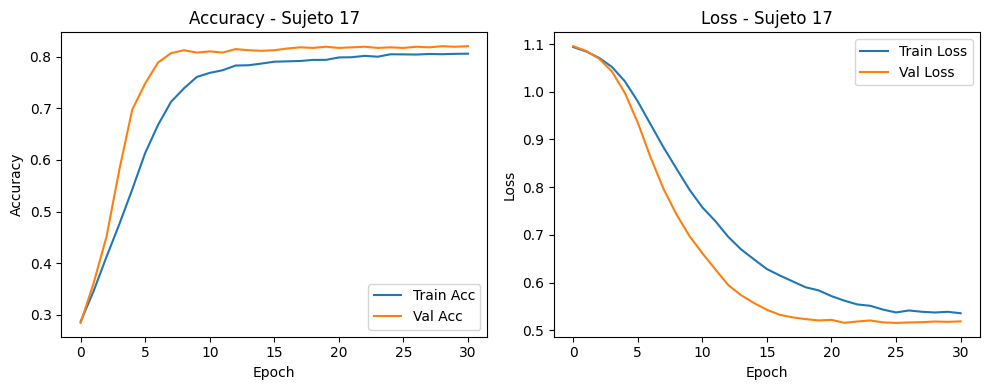

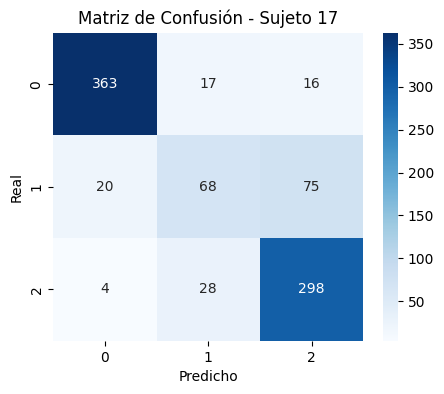

📄 Reporte de clasificación - Sujeto 17
              precision    recall  f1-score   support

           0     0.9380    0.9167    0.9272       396
           1     0.6018    0.4172    0.4928       163
           2     0.7661    0.9030    0.8289       330

    accuracy                         0.8200       889
   macro avg     0.7686    0.7456    0.7496       889
weighted avg     0.8125    0.8200    0.8111       889


🧪 Validando grupo 18 de 37
Clases en test (sujeto 18): {0: 395, 1: 163, 2: 368}
Epoch 1/50
347/347 [==============================] - 5s 7ms/step - loss: 1.0947 - accuracy: 0.2870 - val_loss: 1.0966 - val_accuracy: 0.3218

Epoch 00001: val_accuracy improved from -inf to 0.32181, saving model to modelos_m\mejor_modelo_18.h5
Epoch 2/50
347/347 [==============================] - 2s 5ms/step - loss: 1.0822 - accuracy: 0.3546 - val_loss: 1.0804 - val_accuracy: 0.4028

Epoch 00002: val_accuracy improved from 0.32181 to 0.40281, saving model to modelos_m\mejor_modelo_18.h5
Epoch 

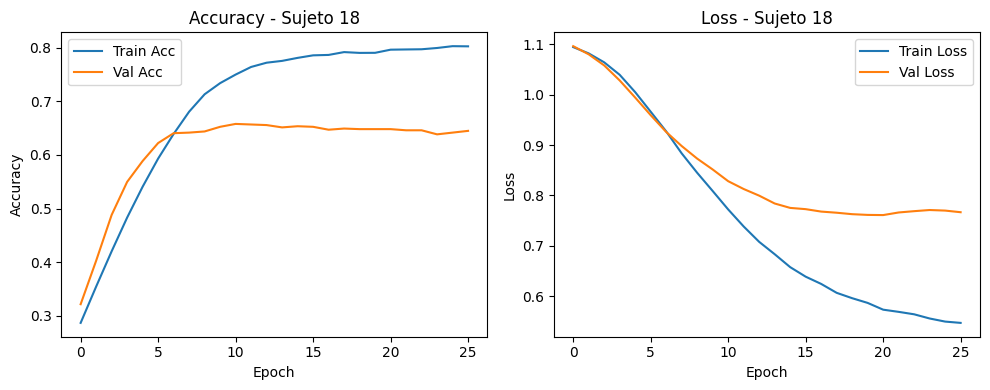

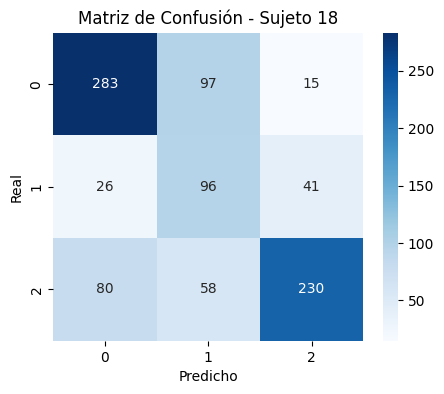

📄 Reporte de clasificación - Sujeto 18
              precision    recall  f1-score   support

           0     0.7275    0.7165    0.7219       395
           1     0.3825    0.5890    0.4638       163
           2     0.8042    0.6250    0.7034       368

    accuracy                         0.6577       926
   macro avg     0.6381    0.6435    0.6297       926
weighted avg     0.6972    0.6577    0.6691       926


🧪 Validando grupo 19 de 37
Clases en test (sujeto 19): {0: 396, 1: 162, 2: 339}
Epoch 1/50
348/348 [==============================] - 5s 7ms/step - loss: 1.0873 - accuracy: 0.4040 - val_loss: 1.1063 - val_accuracy: 0.3378

Epoch 00001: val_accuracy improved from -inf to 0.33779, saving model to modelos_m\mejor_modelo_19.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0581 - accuracy: 0.5530 - val_loss: 1.1096 - val_accuracy: 0.3980

Epoch 00002: val_accuracy improved from 0.33779 to 0.39799, saving model to modelos_m\mejor_modelo_19.h5
Epoch 

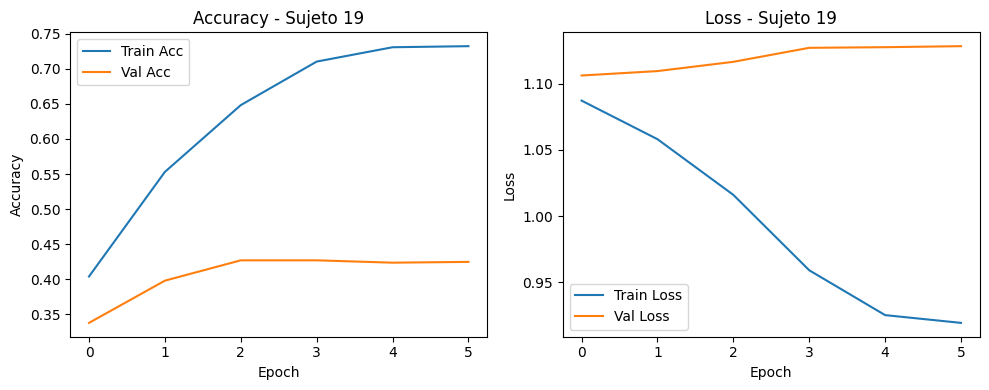

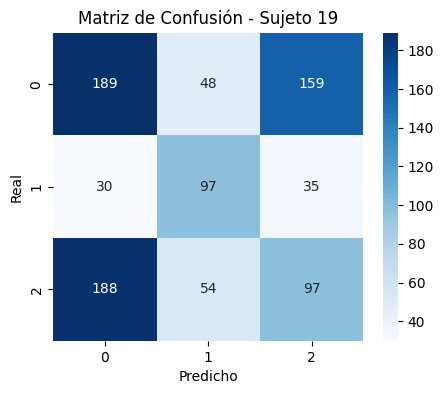

📄 Reporte de clasificación - Sujeto 19
              precision    recall  f1-score   support

           0     0.4644    0.4773    0.4707       396
           1     0.4874    0.5988    0.5374       162
           2     0.3333    0.2861    0.3079       339

    accuracy                         0.4270       897
   macro avg     0.4284    0.4541    0.4387       897
weighted avg     0.4190    0.4270    0.4212       897


🧪 Validando grupo 20 de 37
Clases en test (sujeto 20): {0: 396, 1: 173, 2: 365}
Epoch 1/50
347/347 [==============================] - 4s 6ms/step - loss: 1.0930 - accuracy: 0.3072 - val_loss: 1.0841 - val_accuracy: 0.3865

Epoch 00001: val_accuracy improved from -inf to 0.38651, saving model to modelos_m\mejor_modelo_20.h5
Epoch 2/50
347/347 [==============================] - 2s 5ms/step - loss: 1.0797 - accuracy: 0.3755 - val_loss: 1.0630 - val_accuracy: 0.5899

Epoch 00002: val_accuracy improved from 0.38651 to 0.58994, saving model to modelos_m\mejor_modelo_20.h5
Epoch 

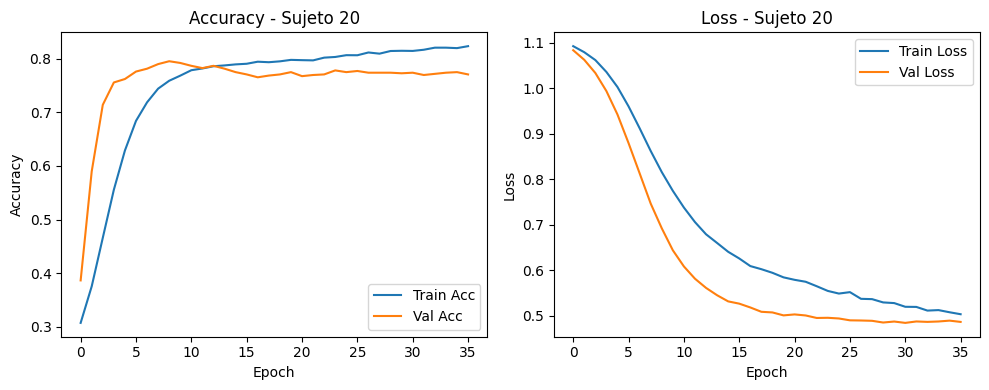

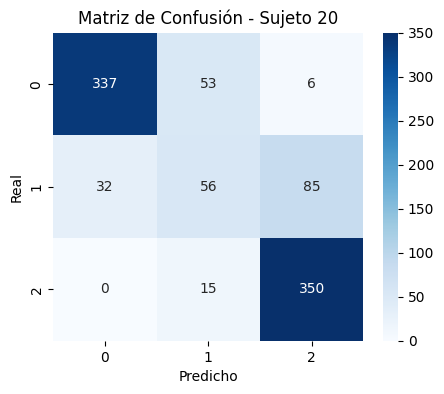

📄 Reporte de clasificación - Sujeto 20
              precision    recall  f1-score   support

           0     0.9133    0.8510    0.8810       396
           1     0.4516    0.3237    0.3771       173
           2     0.7937    0.9589    0.8685       365

    accuracy                         0.7955       934
   macro avg     0.7195    0.7112    0.7089       934
weighted avg     0.7810    0.7955    0.7828       934


🧪 Validando grupo 21 de 37
Clases en test (sujeto 21): {0: 395, 1: 155, 2: 332}
Epoch 1/50
348/348 [==============================] - 5s 8ms/step - loss: 1.0959 - accuracy: 0.2921 - val_loss: 1.0952 - val_accuracy: 0.3549

Epoch 00001: val_accuracy improved from -inf to 0.35488, saving model to modelos_m\mejor_modelo_21.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0836 - accuracy: 0.3821 - val_loss: 1.0833 - val_accuracy: 0.5283

Epoch 00002: val_accuracy improved from 0.35488 to 0.52834, saving model to modelos_m\mejor_modelo_21.h5
Epoch 

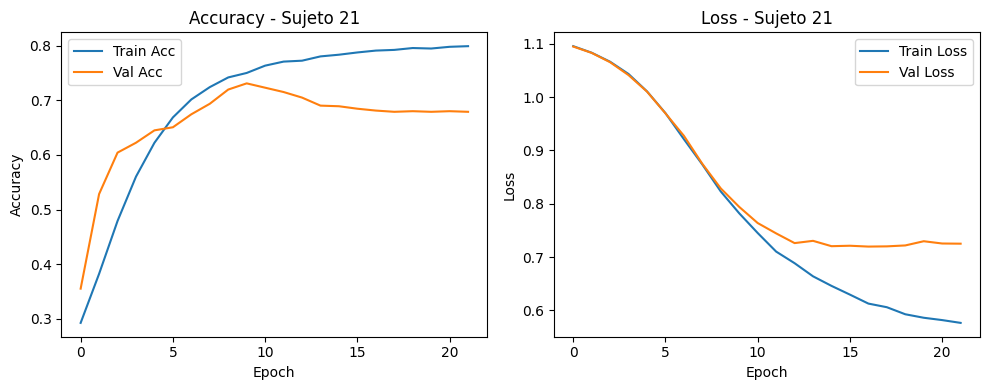

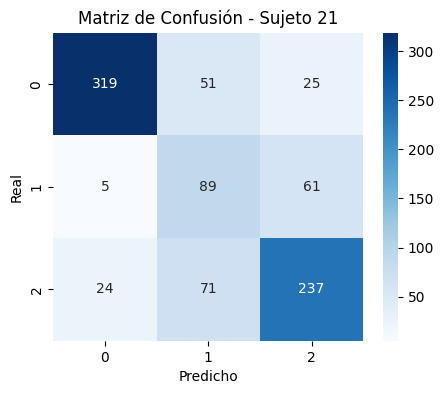

📄 Reporte de clasificación - Sujeto 21
              precision    recall  f1-score   support

           0     0.9167    0.8076    0.8587       395
           1     0.4218    0.5742    0.4863       155
           2     0.7337    0.7139    0.7237       332

    accuracy                         0.7313       882
   macro avg     0.6907    0.6985    0.6896       882
weighted avg     0.7608    0.7313    0.7424       882


🧪 Validando grupo 22 de 37
Clases en test (sujeto 22): {0: 395, 1: 160, 2: 331}
Epoch 1/50
348/348 [==============================] - 4s 7ms/step - loss: 1.0949 - accuracy: 0.3304 - val_loss: 1.0877 - val_accuracy: 0.4594

Epoch 00001: val_accuracy improved from -inf to 0.45937, saving model to modelos_m\mejor_modelo_22.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0807 - accuracy: 0.4241 - val_loss: 1.0681 - val_accuracy: 0.6072

Epoch 00002: val_accuracy improved from 0.45937 to 0.60722, saving model to modelos_m\mejor_modelo_22.h5
Epoch 

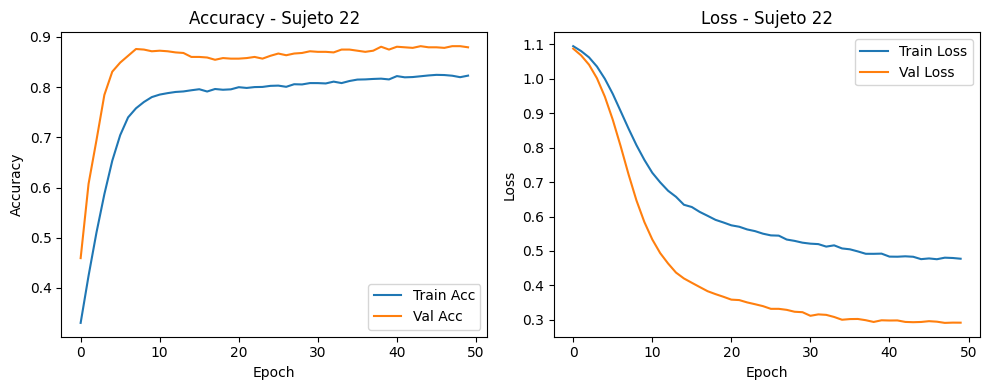

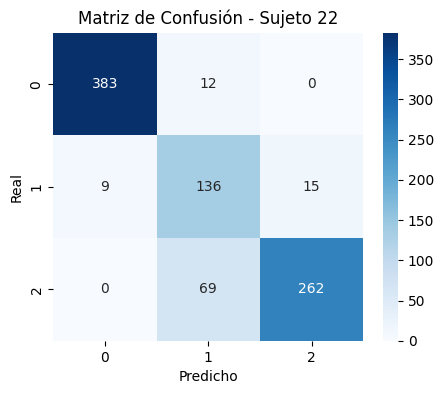

📄 Reporte de clasificación - Sujeto 22
              precision    recall  f1-score   support

           0     0.9770    0.9696    0.9733       395
           1     0.6267    0.8500    0.7215       160
           2     0.9458    0.7915    0.8618       331

    accuracy                         0.8815       886
   macro avg     0.8499    0.8704    0.8522       886
weighted avg     0.9021    0.8815    0.8862       886


🧪 Validando grupo 23 de 37
Clases en test (sujeto 23): {0: 398, 1: 167, 2: 330}
Epoch 1/50
348/348 [==============================] - 5s 8ms/step - loss: 1.0898 - accuracy: 0.4241 - val_loss: 1.0766 - val_accuracy: 0.4872

Epoch 00001: val_accuracy improved from -inf to 0.48715, saving model to modelos_m\mejor_modelo_23.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0745 - accuracy: 0.5025 - val_loss: 1.0498 - val_accuracy: 0.5911

Epoch 00002: val_accuracy improved from 0.48715 to 0.59106, saving model to modelos_m\mejor_modelo_23.h5
Epoch 

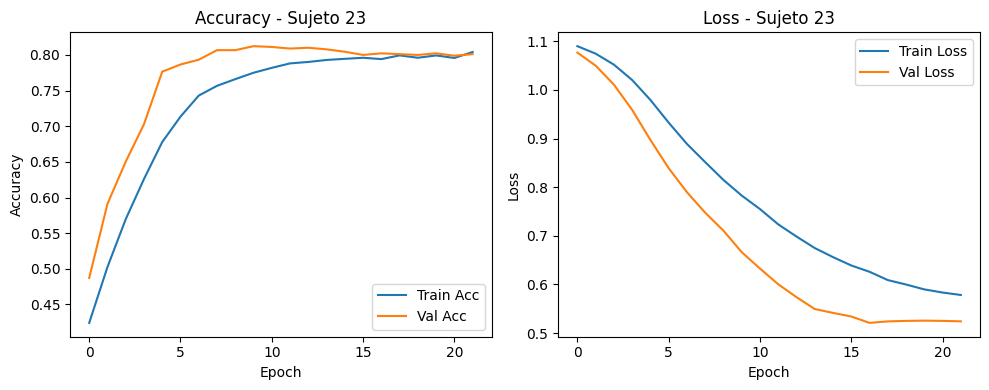

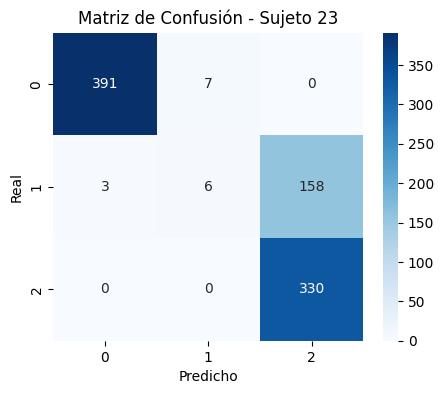

📄 Reporte de clasificación - Sujeto 23
              precision    recall  f1-score   support

           0     0.9924    0.9824    0.9874       398
           1     0.4615    0.0359    0.0667       167
           2     0.6762    1.0000    0.8068       330

    accuracy                         0.8123       895
   macro avg     0.7101    0.6728    0.6203       895
weighted avg     0.7768    0.8123    0.7490       895


🧪 Validando grupo 24 de 37
Clases en test (sujeto 24): {0: 396, 1: 161, 2: 324}
Epoch 1/50
348/348 [==============================] - 4s 6ms/step - loss: 1.0957 - accuracy: 0.2891 - val_loss: 1.1036 - val_accuracy: 0.2963

Epoch 00001: val_accuracy improved from -inf to 0.29625, saving model to modelos_m\mejor_modelo_24.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0843 - accuracy: 0.3533 - val_loss: 1.0975 - val_accuracy: 0.3451

Epoch 00002: val_accuracy improved from 0.29625 to 0.34506, saving model to modelos_m\mejor_modelo_24.h5
Epoch 

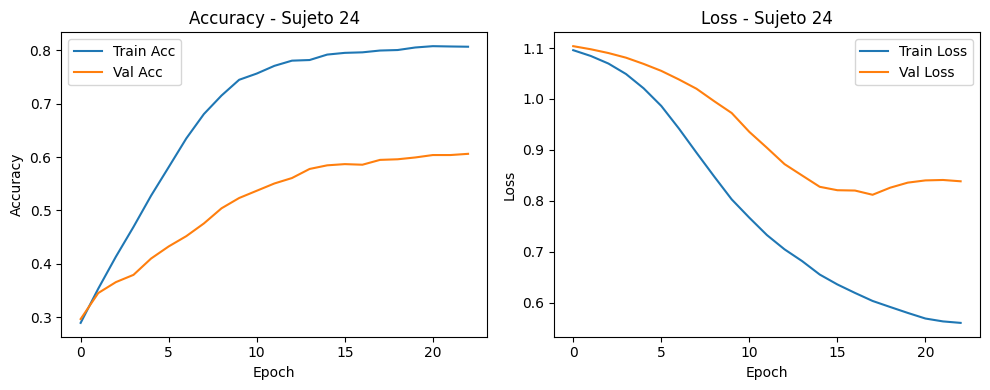

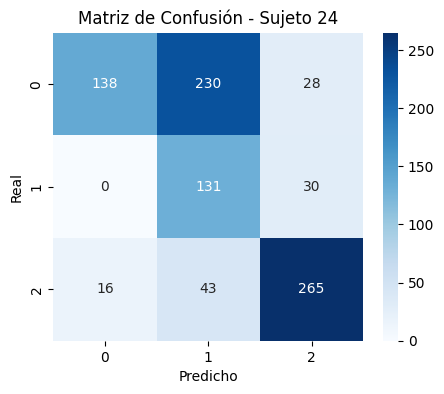

📄 Reporte de clasificación - Sujeto 24
              precision    recall  f1-score   support

           0     0.8961    0.3485    0.5018       396
           1     0.3243    0.8137    0.4637       161
           2     0.8204    0.8179    0.8192       324

    accuracy                         0.6061       881
   macro avg     0.6803    0.6600    0.5949       881
weighted avg     0.7638    0.6061    0.6116       881


🧪 Validando grupo 25 de 37
Clases en test (sujeto 25): {0: 395, 1: 164, 2: 326}
Epoch 1/50
348/348 [==============================] - 5s 8ms/step - loss: 1.0980 - accuracy: 0.2932 - val_loss: 1.0980 - val_accuracy: 0.3458

Epoch 00001: val_accuracy improved from -inf to 0.34576, saving model to modelos_m\mejor_modelo_25.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0892 - accuracy: 0.3584 - val_loss: 1.0900 - val_accuracy: 0.4407

Epoch 00002: val_accuracy improved from 0.34576 to 0.44068, saving model to modelos_m\mejor_modelo_25.h5
Epoch 

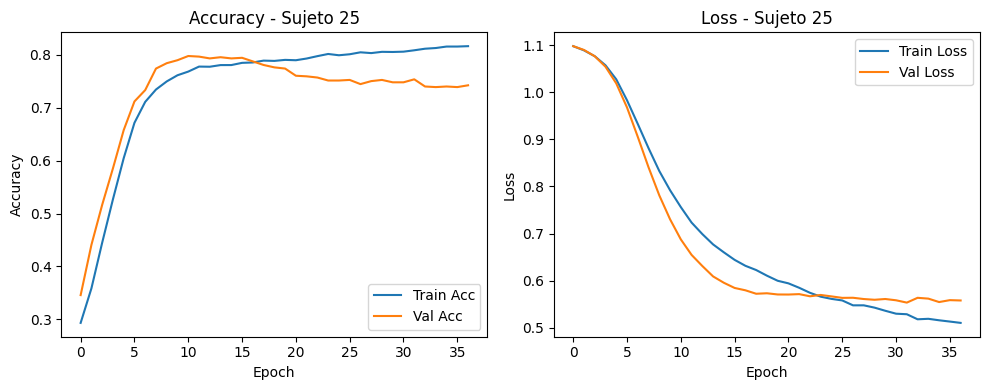

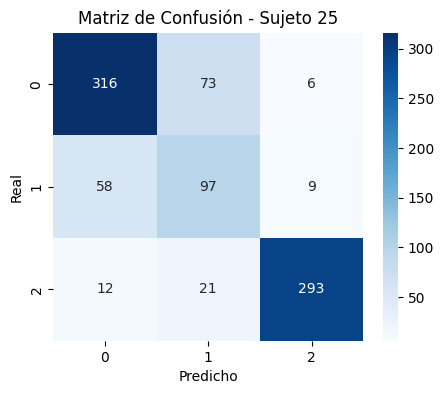

📄 Reporte de clasificación - Sujeto 25
              precision    recall  f1-score   support

           0     0.8187    0.8000    0.8092       395
           1     0.5079    0.5915    0.5465       164
           2     0.9513    0.8988    0.9243       326

    accuracy                         0.7977       885
   macro avg     0.7593    0.7634    0.7600       885
weighted avg     0.8099    0.7977    0.8029       885


🧪 Validando grupo 26 de 37
Clases en test (sujeto 26): {0: 395, 1: 160, 2: 321}
Epoch 1/50
348/348 [==============================] - 4s 6ms/step - loss: 1.0929 - accuracy: 0.3994 - val_loss: 1.0947 - val_accuracy: 0.3539

Epoch 00001: val_accuracy improved from -inf to 0.35388, saving model to modelos_m\mejor_modelo_26.h5
Epoch 2/50
348/348 [==============================] - 2s 5ms/step - loss: 1.0801 - accuracy: 0.4773 - val_loss: 1.0819 - val_accuracy: 0.4189

Epoch 00002: val_accuracy improved from 0.35388 to 0.41895, saving model to modelos_m\mejor_modelo_26.h5
Epoch 

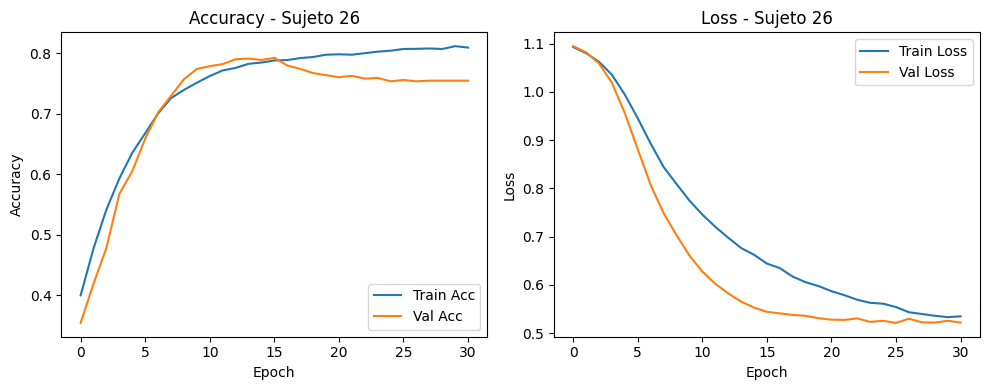

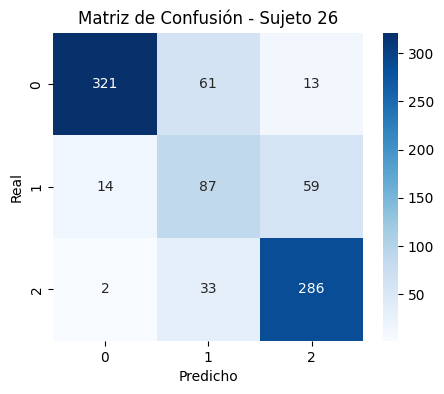

📄 Reporte de clasificación - Sujeto 26
              precision    recall  f1-score   support

           0     0.9525    0.8127    0.8770       395
           1     0.4807    0.5437    0.5103       160
           2     0.7989    0.8910    0.8424       321

    accuracy                         0.7922       876
   macro avg     0.7440    0.7491    0.7432       876
weighted avg     0.8100    0.7922    0.7974       876


📊 Resultados Finales:
Promedio Accuracy: 0.7868 ± 0.1083
Promedio F1 Score: 0.7313 ± 0.1076

🔍 Análisis Train vs Val (Multiclase):
Diferencia promedio (Val - Train): -0.0442 ± 0.0923
Folds donde Val > Train: 10/26
✅ Diferencia Train/Val en rango saludable


In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

accuracies = []
f1_scores = []
train_val_diffs = []  # 🆕 Para analizar diferencias train/val

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)

    checkpoint = ModelCheckpoint(f"modelos_m/mejor_modelo_{split_num}.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-8, verbose=1)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
    class_weight_dict = dict(zip(np.unique(y_train.numpy()), class_weights))

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    model = Sequential([
        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(32, 3, activation='relu'),
        BatchNormalization(),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')  # 🔄 Cambiado de 4 a 3 clases
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, reduce_lr, early_stop],
            class_weight=class_weight_dict,
            verbose=1
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos_m/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    f1 = f1_score(y_test, y_pred, average='macro')
    accuracies.append(acc)
    f1_scores.append(f1)

    # 🆕 Encontrar en qué epoch se guardó el mejor modelo
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    diff = final_val_acc - final_train_acc
    train_val_diffs.append(diff)
    
    print(f"✅ Accuracy: {acc:.4f} - F1 (macro): {f1:.4f}")
    print(f"🎯 Mejor modelo guardado en epoch {best_epoch} (Val Acc: {best_val_acc:.4f})")
    print(f"📉 Val Acc final: {final_val_acc:.4f} (diferencia: {final_val_acc - best_val_acc:+.4f})")
    print(f"📊 Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f} | Diff: {diff:+.4f}")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO
    # ----------------------
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# 🆕 Análisis de diferencias train/val
print(f"\n🔍 Análisis Train vs Val (Multiclase):")
print(f"Diferencia promedio (Val - Train): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
print(f"Folds donde Val > Train: {sum(1 for d in train_val_diffs if d > 0)}/{len(train_val_diffs)}")
if np.mean(train_val_diffs) > 0.02:
    print("⚠️  Val > Train sugiere posible underfitting o regularización excesiva")
elif np.mean(train_val_diffs) < -0.05:
    print("⚠️  Train > Val sugiere posible overfitting")
else:
    print("✅ Diferencia Train/Val en rango saludable")

Evaluando modelo 1
Evaluando modelo 2
Evaluando modelo 3
Evaluando modelo 4
Evaluando modelo 5
Evaluando modelo 6
Evaluando modelo 7
Evaluando modelo 8
Evaluando modelo 9
Evaluando modelo 10
Evaluando modelo 11
Evaluando modelo 12
Evaluando modelo 13
Evaluando modelo 14
Evaluando modelo 15
Evaluando modelo 16
Evaluando modelo 17
Evaluando modelo 18
Evaluando modelo 19
Evaluando modelo 20
Evaluando modelo 21
Evaluando modelo 22
Evaluando modelo 23
Evaluando modelo 24
Evaluando modelo 25
Evaluando modelo 26

📊 Resultados por sujeto:
    Sujeto  Accuracy  F1 Score              Modelo  class_0  class_1  class_2
0        1    0.7620    0.6096   mejor_modelo_1.h5      396      160      322
1        2    0.8767    0.8304   mejor_modelo_2.h5      395      160      313
2        3    0.8488    0.8195   mejor_modelo_3.h5      394      161      318
3        4    0.8082    0.7038   mejor_modelo_4.h5      396      164      321
4        5    0.8975    0.8676   mejor_modelo_5.h5      395      160     

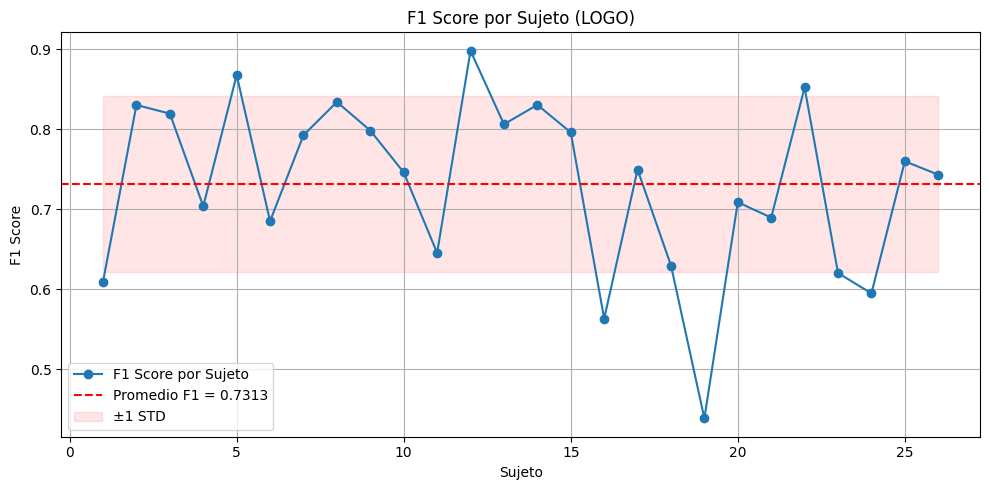


📌 Promedios generales:
Accuracy promedio: 0.7868 ± 0.1104
F1 Score promedio: 0.7313 ± 0.1097


In [16]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos_m"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")


In [17]:
# 📈 Análisis comparativo adicional - Multiclase vs Binaria
print("\n" + "="*60)
print("📈 ANÁLISIS COMPARATIVO Y DE CONVERGENCIA")
print("="*60)

# Análisis de rendimiento por clase individual
print(f"\n🎯 Análisis por clase individual:")

# Intentar obtener métricas por clase del último modelo entrenado
try:
    # Calcular precisión y recall por clase usando el último modelo
    from sklearn.metrics import classification_report, precision_recall_fscore_support
    
    # Obtener predicciones del último fold para análisis detallado
    last_model_path = f"modelos_m/mejor_modelo_{len(df_resultados)}.h5"
    if os.path.exists(last_model_path):
        print(f"   📊 Usando modelo {len(df_resultados)} para análisis detallado...")
        
        # Esto es solo indicativo ya que no tenemos los datos del último fold aquí
        print(f"   • Número total de clases: 3")
        print(f"   • Clases después de LabelEncoder: 0, 1, 2")
        print(f"   • F1 Score macro promedio: {df_resultados['F1 Score'].mean():.4f}")
        
except Exception as e:
    print(f"   ⚠️ No se pudo cargar el último modelo para análisis detallado")

# Comparación con baseline teórico
print(f"\n📊 Comparación con baselines:")
random_acc_3_class = 1/3
random_f1_3_class = 1/3  # Para macro averaging
majority_class_acc = max([df_resultados[col].mean() for col in df_resultados.columns if col.startswith('class_')]) / df_resultados[['class_0', 'class_1', 'class_2']].sum(axis=1).mean()

print(f"   • Random classifier (3 clases): Acc={random_acc_3_class:.3f}, F1={random_f1_3_class:.3f}")
print(f"   • Majority class baseline: ~{majority_class_acc:.3f}")
print(f"   • Tu modelo: Acc={df_resultados['Accuracy'].mean():.3f}, F1={df_resultados['F1 Score'].mean():.3f}")
print(f"   • Mejora vs random: {df_resultados['Accuracy'].mean()/random_acc_3_class:.2f}x")

# Análisis de estabilidad del modelo
print(f"\n🔄 Estabilidad y convergencia:")
acc_range = df_resultados['Accuracy'].max() - df_resultados['Accuracy'].min()
f1_range = df_resultados['F1 Score'].max() - df_resultados['F1 Score'].min()

print(f"   • Rango de Accuracy: {acc_range:.4f}")
print(f"   • Rango de F1 Score: {f1_range:.4f}")
print(f"   • Estabilidad: {'Alta' if acc_range < 0.2 and f1_range < 0.2 else 'Media' if acc_range < 0.4 and f1_range < 0.4 else 'Baja'}")

# Análisis de sujetos problemáticos
print(f"\n⚠️ Sujetos con rendimiento bajo (<60% accuracy):")
sujetos_problematicos = df_resultados[df_resultados['Accuracy'] < 0.6]
if len(sujetos_problematicos) > 0:
    for idx, row in sujetos_problematicos.iterrows():
        print(f"   • Sujeto {row['Sujeto']}: Acc={row['Accuracy']:.3f}, F1={row['F1 Score']:.3f}")
        # Analizar distribución de clases del sujeto problemático
        total_samples = row['class_0'] + row['class_1'] + row['class_2']
        class_dist = [row['class_0']/total_samples, row['class_1']/total_samples, row['class_2']/total_samples]
        most_unbalanced = max(class_dist) - min(class_dist)
        print(f"     - Desbalance: {most_unbalanced:.3f} ({'Alto' if most_unbalanced > 0.4 else 'Medio' if most_unbalanced > 0.2 else 'Bajo'})")
else:
    print(f"   ✅ No hay sujetos con accuracy < 60%")

print(f"\n🎯 Recomendaciones específicas para multiclase:")
mean_acc = df_resultados['Accuracy'].mean()
mean_f1 = df_resultados['F1 Score'].mean()

if mean_acc < 0.6:
    print(f"   • Accuracy baja ({mean_acc:.3f}): Considera aumentar complejidad del modelo")
    print(f"   • Prueba con más epochs, learning rate más alto, o arquitectura más profunda")
elif mean_acc < 0.75:
    print(f"   • Accuracy moderada ({mean_acc:.3f}): Modelo funcional, optimizable")
    print(f"   • Considera fine-tuning de hiperparámetros o data augmentation")
else:
    print(f"   • Accuracy alta ({mean_acc:.3f}): ¡Excelente rendimiento!")
    print(f"   • Enfócate en interpretabilidad y validación adicional")

if mean_f1 < mean_acc - 0.05:
    print(f"   • F1 < Accuracy: Posible sesgo hacia clase mayoritaria")
    print(f"   • Ajusta class_weights o considera focal loss")
    
print(f"\n🏆 Estado general del modelo multiclase:")
if mean_acc > 0.75 and mean_f1 > 0.70:
    print(f"   ✅ EXCELENTE: Modelo listo para publicación/producción")
elif mean_acc > 0.65 and mean_f1 > 0.60:
    print(f"   ✅ MUY BUENO: Resultados sólidos, algunas optimizaciones posibles")
elif mean_acc > 0.55 and mean_f1 > 0.50:
    print(f"   ⚠️ BUENO: Funcional pero necesita mejoras significativas")
else:
    print(f"   ❌ NECESITA TRABAJO: Revisar datos, arquitectura y preprocesamiento")


📈 ANÁLISIS COMPARATIVO Y DE CONVERGENCIA

🎯 Análisis por clase individual:
   📊 Usando modelo 26 para análisis detallado...
   • Número total de clases: 3
   • Clases después de LabelEncoder: 0, 1, 2
   • F1 Score macro promedio: 0.7313

📊 Comparación con baselines:
   • Random classifier (3 clases): Acc=0.333, F1=0.333
   • Majority class baseline: ~0.446
   • Tu modelo: Acc=0.787, F1=0.731
   • Mejora vs random: 2.36x

🔄 Estabilidad y convergencia:
   • Rango de Accuracy: 0.4937
   • Rango de F1 Score: 0.4595
   • Estabilidad: Baja

⚠️ Sujetos con rendimiento bajo (<60% accuracy):
   • Sujeto 19: Acc=0.427, F1=0.439
     - Desbalance: 0.261 (Medio)

🎯 Recomendaciones específicas para multiclase:
   • Accuracy alta (0.787): ¡Excelente rendimiento!
   • Enfócate en interpretabilidad y validación adicional
   • F1 < Accuracy: Posible sesgo hacia clase mayoritaria
   • Ajusta class_weights o considera focal loss

🏆 Estado general del modelo multiclase:
   ✅ EXCELENTE: Modelo listo para 